# River Crossing Problem: Notebook Overview

Solve the classic river-crossing planning problem using Spectra.


## Domain & Background
- Domain objects: `sheep`, `cabbage`, `wolf`, `left`, `right`.
- Background facts and axioms include:
    - Conflict relations: `Conflict wolf sheep`, `Conflict sheep cabbage`, and symmetry/irreﬂexivity axioms.
    - Shore and object declarations (`Shore left/right`, `Object ...`).
    - Uniqueness and consistency constraints (e.g., boat ≠ left, object-on-shore uniqueness).

## Actions
Three parameterized actions are defined:
- `LoadBoat ?obj ?shore` — load an object onto the boat if object and boat are on the same shore.
- `UnLoadBoat ?obj ?shore` — unload an object from the boat to the shore where the boat is.
- `MoveBoat ?shore1 ?shore2` — move the boat between shores (requires boat at source).

Actions include preconditions, add/delete effects, and postconditions to capture conflicts and exclusivity.

## Initial State and Goal
- Initial state (`start`): `On wolf left`, `On sheep left`, `On cabbage left`, `At boat left` (none on the boat).
- Goal (`goal`): all objects on right shore:
    - `(and (On wolf right) (On sheep right) (On cabbage right))`


## Plan Found
A plan of length 17 was found (sequence of actions executed in order):
1. `(LoadBoat sheep left)`
2. `(MoveBoat left right)`
3. `(UnLoadBoat sheep right)`
4. `(MoveBoat right left)`
5. `(LoadBoat wolf left)`
6. `(MoveBoat left right)`
7. `(UnLoadBoat wolf right)`
8. `(LoadBoat sheep right)`
9. `(MoveBoat right left)`
10. `(UnLoadBoat sheep left)`
11. `(LoadBoat cabbage left)`
12. `(MoveBoat left right)`
13. `(UnLoadBoat cabbage right)`
14. `(MoveBoat right left)`
15. `(LoadBoat sheep left)`
16. `(MoveBoat left right)`
17. `(UnLoadBoat sheep right)`



In [1]:
import os
os.environ['EPROVER_HOME'] = './eprover/'
from shadowprover.syntax import *
from shadowprover.reasoners.planner import Action
from shadowprover.syntax.reader import r

from functools import cache

from shadowprover.experimental.sst_prover import SST_Prover
from shadowprover.reasoners.planner import run_spectra
from shadowprover.fol.fol_prover import fol_prove


/home/eichc/miniconda3/envs/spectra_env/lib/python3.11/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


### Domain Definition

In [2]:
domain = {r("wolf"), r("sheep"), r("cabbage"), r("left"), r("right")}

background = set(
    list(
        map(
            r,
            [
                "(forall [?x ?y] (if (Conflict ?x ?y) (Conflict ?y ?x)))",
                "(Conflict wolf sheep)",
                "(Conflict sheep cabbage)",
                "(not (Conflict wolf cabbage))",
                "(Shore left)",
                "(Shore right)",
                "(Object wolf)",
                "(Object sheep)",
                "(Object cabbage)",
                "(not (= left right))",
                "(forall [?x] (if (Object ?x) (or (= ?x wolf) (= ?x sheep) (= ?x cabbage) )))",
                "(forall [?x ?y ?z] (if (and (On ?x ?y) (On ?x ?z)) (= ?y ?z) ))",
                "(not (= boat left))",
                "(not (= left right))",
                "(forall [?x] (not (Conflict ?x ?x)))",
            ],
        )
    )
)


actions = [
    Action(
        r("(LoadBoat ?obj ?shore)"),
        precondition=r(
            """(and 
                            
                                    (Shore ?shore) 
                                    (Object ?obj)  
                                    (On ?obj ?shore) 
                                    (At boat ?shore))"""
        ),
        additions={
            r("(On ?obj boat)"),
        },
        deletions={r("(On ?obj ?shore)"), r("(not (On ?obj boat))")},
        postconditions={
            r(
                "(or (At boat ?shore) (forall [?c] (if (and (Object ?c) (On ?c boat)) (not (Conflict ?c ?obj)))))"
            ),
            r(
                "(forall [?obj ?y] (if (and (On ?obj boat) (On ?y boat)) (= ?obj ?y) ) )"
            ),
        },
    ),
    Action(
        r("(UnLoadBoat ?obj ?shore)"),
        precondition=r(
            """(and 
                                    (Shore ?shore) 
                                    (Object ?obj) 
                                    (On ?obj boat) 
                                    (At boat ?shore)

                                    )"""
        ),
        additions={r("(On ?obj ?shore)"), r("(not (On ?obj boat))")},
        deletions={
            r("(On ?obj boat)"),
        },
        postconditions={
            r(
                "(or (At boat ?shore) (forall [?c] (if (and (Object ?c) (On ?c ?shore)) (not (Conflict ?c ?obj)))))"
            )
        },
    ),
    Action(
        r("(MoveBoat ?shore1 ?shore2)"),
        precondition=r(
            """(and 
                            (Shore ?shore1) (Shore ?shore2) (not (= ?shore1 ?shore2)) (At boat ?shore1))"""
        ),
        additions={
            r("(At boat ?shore2)"),
        },
        deletions={
            r("(At boat ?shore1)"),
        },
        postconditions={
            r(
                "(forall [?c ?d] (if (and (Object ?c) (Object ?d) (On ?c ?shore1) (On ?d ?shore1)) (not (Conflict ?c ?d))))"
            )
        },
    ),
]
start = set(
    map(
        r,
        [
            "(On wolf left)",
            "(On cabbage left)",
            "(On sheep left)",
            "(At boat left)",
            "(not (On wolf boat))",
            "(not (On sheep boat))",
            "(not (On cabbage boat))",
        ],
    )
)

completions = ["On"]
goal = r(
    """
        (and (On wolf right)  (On sheep right) (On cabbage right))
    """
)
avoid_condition_1 = r(" (if (previous LoadBoat) (not (Next UnLoadBoat)))")
avoid_condition_2 = r(" (if (previous MoveBoat) (not (Next MoveBoat)))")
avoid_condition_3 = r(" (not (first UnLoadBoat))")
avoid_condition_4 = r(" (not (first MoveBoat))")

meta_conditions = {
                avoid_condition_1,
                avoid_condition_2,
                avoid_condition_3,
                avoid_condition_4,
                
                
                }

### Initialize Reasoner

In [3]:
sst = SST_Prover()
def get_cached_prover(find_answer=True, max_answers=5):
    @cache
    def cached_prover(inputs, output, find_answer=find_answer, max_answers=max_answers):
        return fol_prove(inputs, output, find_answer=find_answer, max_answers=max_answers)
    
    def _prover_(inputs, output, find_answer=find_answer, max_answers=max_answers):
        return cached_prover(frozenset(inputs), output, find_answer, max_answers=max_answers)
    
    return _prover_

### Generate Plan

In [4]:
result = run_spectra(domain, background, start, goal, actions, get_cached_prover(), completions=completions, meta_conditions=meta_conditions, verbose=False)[0]

result 

[(LoadBoat sheep left),
 (MoveBoat left right),
 (UnLoadBoat sheep right),
 (MoveBoat right left),
 (LoadBoat cabbage left),
 (MoveBoat left right),
 (UnLoadBoat cabbage right),
 (LoadBoat sheep right),
 (MoveBoat right left),
 (UnLoadBoat sheep left),
 (LoadBoat wolf left),
 (MoveBoat left right),
 (UnLoadBoat wolf right),
 (MoveBoat right left),
 (LoadBoat sheep left),
 (MoveBoat left right),
 (UnLoadBoat sheep right)]

### [Optional] Generate Plan (With Visualization)

In [5]:
from PIL import Image, ImageDraw
from IPython.display import display, clear_output

from PIL import Image, ImageDraw
from IPython.display import display, clear_output

colors = {
    "sheep": "gray",
    "tiger": "yellow",
    "cabbage": "green",
    "wolf": "orange",
    
}

items = colors.keys()
def _visualize_world_(left=[], right=[], on_boat=[], boat_position="left"):
    width, height = 1000, 350
    image = Image.new('RGB', (width, height), 'white')
    draw = ImageDraw.Draw(image)
    
    y_point = 50
    shore_padding = 75
    left_bank = width//2 -150
    right_bank = width//2 + 150
    point_radius = 5
    boat_position_left = left_bank
    boat_position_right = right_bank
    boat_width = 40
    draw.rectangle(
        [left_bank, 40, right_bank, height - 10],
        outline='royalblue', width=2, fill="royalblue"
    )
    
    for i, item in enumerate(left):
        draw.ellipse(
                        [left_bank - shore_padding  - point_radius, (i+1) * shore_padding//2 + y_point - point_radius,
                        left_bank -  shore_padding + point_radius, (i+1) * shore_padding//2 + y_point + point_radius],
                        fill=colors[item]
                    )
        draw.text((left_bank - shore_padding,(i+1) * shore_padding//2+ y_point + 12), item,font_size=15, fill=colors[item], stroke_fill=colors[item])
            
    for i, item in enumerate(right):
        draw.ellipse(
                        [right_bank + shore_padding//2  - point_radius, (i+1) * shore_padding//2 + y_point - point_radius,
                        right_bank + shore_padding//2 + point_radius, (i+1) * shore_padding//2 + y_point + point_radius],
                        fill=colors[item]
                    )
        draw.text((right_bank + shore_padding//2,(i+1) * shore_padding//2 + y_point + 12), item, font_size=15, fill=colors[item], stroke_fill=colors[item])


    boat_coords = ([boat_position_left, 125, boat_position_left+ boat_width, 200] if boat_position == "left" 
                   else [boat_position_right - boat_width, 125, boat_position_right, 200])
    draw.rectangle(
        boat_coords,
        outline='gray', width=2, fill="white"
    )

    for i, item in enumerate(on_boat):
        x, y, xx, yy = boat_coords
        print(item)
        draw.ellipse(
                        [x + 4*point_radius  - point_radius, y + (i+1)* 3* point_radius - point_radius,
                        x + 4*point_radius + point_radius, y+ (i+1)*3 * point_radius  + point_radius],
                        fill=colors[item]
                    )




    return draw, image 
def parse_state(state):
    left = []
    right = []
    on_boat = []
    boat_position = "left"
    for item in items:
        if r(f"(On {item} boat)") in state:
            on_boat = on_boat + [item]
        if r(f"(On {item} left)") in state:
            left = left + [item]
        if r(f"(On {item} right)") in state:
            right = right + [item]  
    if r(f"(At boat right)") in state:
        boat_position = "right"
    return left, right, on_boat, boat_position
    
        


def visualizer(state,plan, plan_found=False, stats=""):
    left, right, on_boat, boat_position = parse_state(state)
    print(left, right, on_boat, boat_position)
    
    draw, image = _visualize_world_(left, right, on_boat, boat_position)
    if not plan_found:
        draw.text((0 , 0), "status: searching", fill='orange', font_size=15, align="left")
        draw.text((150 , 0), str(stats), fill='gray', font_size=12, align="left")
        draw.text((0 , 20), str(plan), fill='red', font_size=15, align="left")
    else:
        draw.text((0 , 0), "status: plan found", fill='green', font_size=15, align="left")
        draw.text((150 , 0), str(stats), fill='gray', font_size=12, align="left")
        draw.text((0 , 20), str(plan), fill='darkgreen', font_size=15, align="left")



    # Show in notebook
    clear_output(wait=True)
    display(image)
    

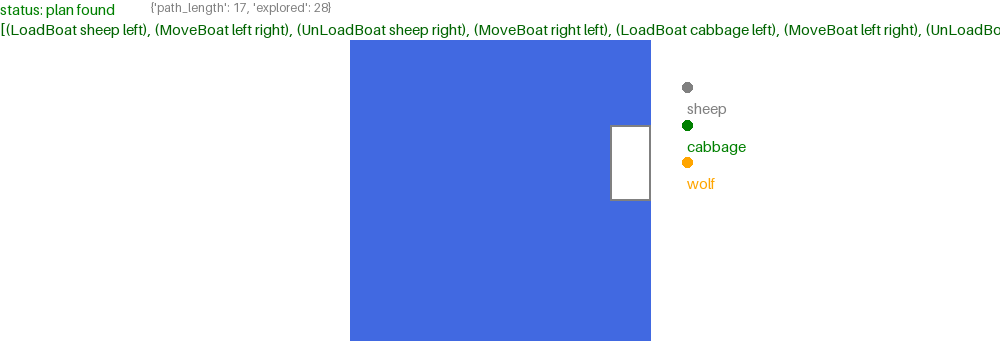

In [6]:
result = run_spectra(domain, background, start, goal, actions, get_cached_prover(), completions=completions, meta_conditions=meta_conditions, verbose=False, visualizer=visualizer)[0]

In [7]:
result

[(LoadBoat sheep left),
 (MoveBoat left right),
 (UnLoadBoat sheep right),
 (MoveBoat right left),
 (LoadBoat cabbage left),
 (MoveBoat left right),
 (UnLoadBoat cabbage right),
 (LoadBoat sheep right),
 (MoveBoat right left),
 (UnLoadBoat sheep left),
 (LoadBoat wolf left),
 (MoveBoat left right),
 (UnLoadBoat wolf right),
 (MoveBoat right left),
 (LoadBoat sheep left),
 (MoveBoat left right),
 (UnLoadBoat sheep right)]